In [104]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime as dt
from collections import Counter
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
total_acorn = pd.read_parquet('total_acorn.gzip')

In [170]:
# read in weather data
weather_df = pd.read_csv('weather.csv')
new_dt=[]
for item in weather_df['DT']:
    item = dt.strptime(item, '%Y-%m-%d').strftime('%Y/%m/%d')
    new_dt.append(item)
weather_df['DT']=new_dt
weather_df=weather_df.set_index(weather_df['DT'])
display(weather_df)

T2M_RANGE    TS  T2MDEW  T2MWET  T2M_MAX  T2M_MIN    T2M  \
DT                                                                     
2012/01/01       4.28  9.84    9.64    9.64    11.34     7.06  10.33   
2012/01/02       1.96  5.59    4.31    4.32     6.84     4.88   5.68   
2012/01/03       6.40  7.79    5.98    5.98    11.71     5.31   8.21   
2012/01/04       5.19  6.04    4.33    4.33     8.52     3.33   6.21   
2012/01/05       4.87  7.78    4.94    4.94    10.17     5.31   8.21   
...               ...   ...     ...     ...      ...      ...    ...   
2014/12/27       5.42  3.02    1.67    1.68     6.80     1.38   2.46   
2014/12/28       6.24  0.56   -0.39   -0.38     4.63    -1.61   0.38   
2014/12/29       5.80  0.67   -0.08   -0.08     3.98    -1.82   0.16   
2014/12/30       6.27  1.09    0.79    0.79     5.04    -1.24   0.89   
2014/12/31       5.88  3.26    2.66    2.66     6.25     0.37   3.50   

            WS50M_RANGE  WS10M_RANGE  WS50M_MIN  WS50M_MAX  WS10M_MIN  \
DT                                                                      
2012/01/01         3.32         3.11       7.94      11.26       5.14   
2012/01/02         3.60         3.03       7.04      10.64       4.75   
2012/01/03        13.29        10.69      10.57      23.86       7.79   
2012/01/04         9.64         7.65       9.52      19.16       6.98   
2012/01/05         8.42         6.93      12.36      20.78       8.89   
...                 ...          ...        ...        ...        ...   
2014/12/27        11.61         9.61       7.91      19.52       5.88   
2014/12/28         5.55         4.59       4.23       9.77       2.84   
2014/12/29         3.15         2.48       4.16       7.31       3.16   
2014/12/30         2.98         1.60       4.12       7.10       3.02   
2014/12/31         5.31         3.76       4.70      10.00       3.37   

            WS10M_MAX  WS50M  WS10M          DT  
DT                                               
2012/01/01       8.25  10.03   7.22  2012/01/01  
2012/01/02       7.77   8.88   6.42  2012/01/02  
2012/01/03      18.48  17.03  12.91  2012/01/03  
2012/01/04      14.62  13.53  10.24  2012/01/04  
2012/01/05      15.83  17.45  13.08  2012/01/05  
...               ...    ...    ...         ...  
2014/12/27      15.49  11.93   9.41  2014/12/27  
2014/12/28       7.44   7.25   5.10  2014/12/28  
2014/12/29       5.64   6.30   4.52  2014/12/29  
2014/12/30       4.62   5.45   3.63  2014/12/30  
2014/12/31       7.14   7.82   5.45  2014/12/31  

[1096 rows x 16 columns]

In [3]:
display(total_acorn)

house_id acorn_group acorn_category
0          MAC000002     ACORN-A       Affluent
1          MAC000002     ACORN-A       Affluent
2          MAC000002     ACORN-A       Affluent
3          MAC000002     ACORN-A       Affluent
4          MAC000002     ACORN-A       Affluent
...              ...         ...            ...
167932469  MAC005565     ACORN-C       Affluent
167932470  MAC005565     ACORN-C       Affluent
167932471  MAC005565     ACORN-C       Affluent
167932472  MAC005565     ACORN-C       Affluent
167932473  MAC005565     ACORN-C       Affluent

[167932474 rows x 3 columns]

In [4]:
total_usage = pd.read_parquet('total_usage.gzip')

In [5]:
display(total_usage)

house_id  treated           date_time  KWH/hh
0          MAC000002    False 2012-10-12 00:30:00   0.000
1          MAC000002    False 2012-10-12 01:00:00   0.000
2          MAC000002    False 2012-10-12 01:30:00   0.000
3          MAC000002    False 2012-10-12 02:00:00   0.000
4          MAC000002    False 2012-10-12 02:30:00   0.000
...              ...      ...                 ...     ...
167926909  MAC005565     True 2012-06-21 05:00:00   0.128
167926910  MAC005565     True 2012-06-21 05:30:00   1.022
167926911  MAC005565     True 2012-06-21 06:00:00   0.188
167926912  MAC005565     True 2012-06-21 06:30:00   0.073
167926913  MAC005565     True 2012-06-21 07:00:00   0.025

[167926914 rows x 4 columns]

In [6]:
grouped_years = total_usage.groupby(total_usage.date_time.dt.year)

In [7]:
# You can see the percent treated rising as non treated drop out
print(grouped_years.mean())

            treated    KWH/hh
date_time                    
2011       0.152039  0.259999
2012       0.197749  0.206861
2013       0.202952  0.210852
2014       0.205529  0.237532


In [8]:
consumption_2012 = total_usage[total_usage.date_time.dt.year == 2012]
consumption_2013 =  total_usage[total_usage.date_time.dt.year == 2013]
consumption_2014 =  total_usage[total_usage.date_time.dt.year == 2014]

In [9]:
print(consumption_2012)

            house_id  treated           date_time  KWH/hh
0          MAC000002    False 2012-10-12 00:30:00   0.000
1          MAC000002    False 2012-10-12 01:00:00   0.000
2          MAC000002    False 2012-10-12 01:30:00   0.000
3          MAC000002    False 2012-10-12 02:00:00   0.000
4          MAC000002    False 2012-10-12 02:30:00   0.000
...              ...      ...                 ...     ...
167926909  MAC005565     True 2012-06-21 05:00:00   0.128
167926910  MAC005565     True 2012-06-21 05:30:00   1.022
167926911  MAC005565     True 2012-06-21 06:00:00   0.188
167926912  MAC005565     True 2012-06-21 06:30:00   0.073
167926913  MAC005565     True 2012-06-21 07:00:00   0.025

[60404512 rows x 4 columns]


In [10]:
# Add a column to the dataframe that tells us the day of the week
# 0 = Monday
tester= consumption_2012.iloc[0]
print(tester['date_time'].weekday())

4


In [11]:
consumption_2012_mon = consumption_2012[consumption_2012.date_time.dt.weekday == 0]
consumption_2012_tues = consumption_2012[consumption_2012.date_time.dt.weekday == 1]
consumption_2012_wed = consumption_2012[consumption_2012.date_time.dt.weekday == 2]
consumption_2012_thurs = consumption_2012[consumption_2012.date_time.dt.weekday == 3]
consumption_2012_fri = consumption_2012[consumption_2012.date_time.dt.weekday == 4]
consumption_2012_sat = consumption_2012[consumption_2012.date_time.dt.weekday == 5]
consumption_2012_sun = consumption_2012[consumption_2012.date_time.dt.weekday == 6]

In [12]:
consumption_2013_mon = consumption_2013[consumption_2013.date_time.dt.weekday == 0]
consumption_2013_tues = consumption_2013[consumption_2013.date_time.dt.weekday == 1]
consumption_2013_wed = consumption_2013[consumption_2013.date_time.dt.weekday == 2]
consumption_2013_thurs = consumption_2013[consumption_2013.date_time.dt.weekday == 3]
consumption_2013_fri = consumption_2013[consumption_2013.date_time.dt.weekday == 4]
consumption_2013_sat = consumption_2013[consumption_2013.date_time.dt.weekday == 5]
consumption_2013_sun = consumption_2013[consumption_2013.date_time.dt.weekday == 6]

In [13]:
consumption_2012_mon_hh_mean = consumption_2012_mon.groupby([consumption_2012_mon['date_time'].dt.time, consumption_2012_mon['treated']]).mean()
consumption_2012_mon_hh_mean = consumption_2012_mon_hh_mean.unstack()

consumption_2012_tues_hh_mean = consumption_2012_tues.groupby([consumption_2012_tues['date_time'].dt.time, consumption_2012_tues['treated']]).mean()
consumption_2012_tues_hh_mean = consumption_2012_tues_hh_mean.unstack()

consumption_2012_sun_hh_mean = consumption_2012_sun.groupby([consumption_2012_sun['date_time'].dt.time, consumption_2012_sun['treated']]).mean()
consumption_2012_sun_hh_mean = consumption_2012_sun_hh_mean.unstack()

In [14]:
consumption_2013_mon_hh_mean = consumption_2013_mon.groupby([consumption_2013_mon['date_time'].dt.time, consumption_2013_mon['treated']]).mean()
consumption_2013_mon_hh_mean = consumption_2013_mon_hh_mean.unstack()

consumption_2013_tues_hh_mean = consumption_2013_tues.groupby([consumption_2013_tues['date_time'].dt.time, consumption_2013_tues['treated']]).mean()
consumption_2013_tues_hh_mean = consumption_2013_tues_hh_mean.unstack()

consumption_2013_sun_hh_mean = consumption_2013_sun.groupby([consumption_2013_sun['date_time'].dt.time, consumption_2013_sun['treated']]).mean()
consumption_2013_sun_hh_mean = consumption_2013_sun_hh_mean.unstack()

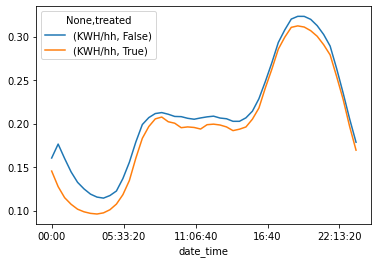

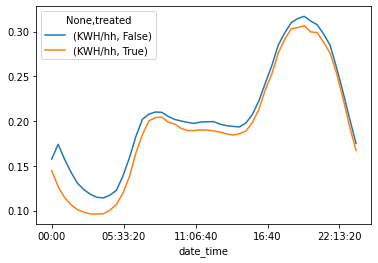

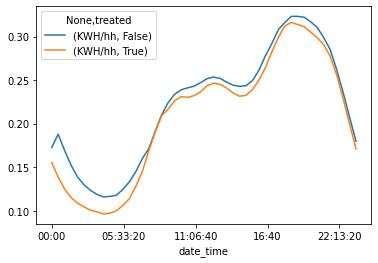

In [15]:
consumption_2012_mon_hh_mean.plot()
plt.show()
consumption_2012_tues_hh_mean.plot()
plt.show()
consumption_2012_sun_hh_mean.plot()
plt.show()

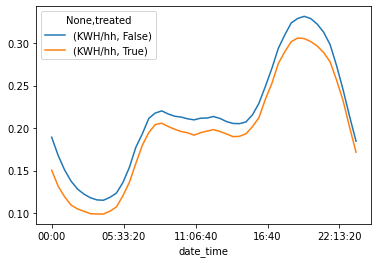

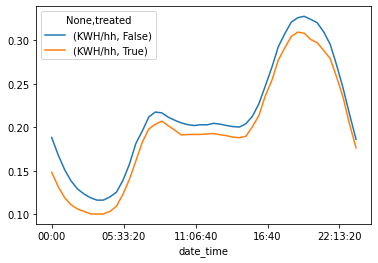

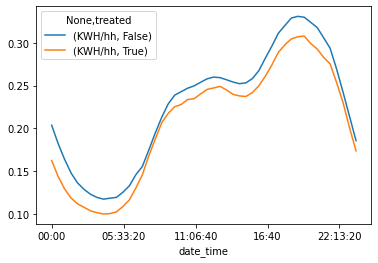

In [16]:
consumption_2013_mon_hh_mean.plot()
plt.show()
consumption_2013_tues_hh_mean.plot()
plt.show()
consumption_2013_sun_hh_mean.plot()
plt.show()

In [77]:
consumption_2012_hh_mean = consumption_2012.groupby([consumption_2012['date_time'], consumption_2012['treated']]).mean()
consumption_2012_hh_mean = consumption_2012_hh_mean.unstack()

consumption_2013_hh_mean = consumption_2013.groupby([consumption_2013['date_time'], consumption_2013['treated']]).mean()
consumption_2013_hh_mean = consumption_2013_hh_mean.unstack()

In [34]:
consumption_2012_hh_mean.head()
print(consumption_2012_hh_mean.columns)

MultiIndex([('KWH/hh', False),
            ('KWH/hh',  True)],
           names=[None, 'treated'])


In [45]:
consumption_2012_hh_mean.head()
consumption_2012_hh_mean_jan = consumption_2012_hh_mean['2012/01/01':'2012/02/01']

In [48]:
consumption_2012_hh_mean_feb = consumption_2012_hh_mean['2012/02/01':'2012/03/01']
consumption_2012_hh_mean_mar = consumption_2012_hh_mean['2012/03/01':'2012/04/01']
consumption_2012_hh_mean_apr = consumption_2012_hh_mean['2012/04/01':'2012/05/01']
consumption_2012_hh_mean_may = consumption_2012_hh_mean['2012/05/01':'2012/06/01']
consumption_2012_hh_mean_jun = consumption_2012_hh_mean['2012/06/01':'2012/07/01']
consumption_2012_hh_mean_jul = consumption_2012_hh_mean['2012/07/01':'2012/08/01']
consumption_2012_hh_mean_aug = consumption_2012_hh_mean['2012/08/01':'2012/09/01']
consumption_2012_hh_mean_sep = consumption_2012_hh_mean['2012/09/01':'2012/10/01']
consumption_2012_hh_mean_nov = consumption_2012_hh_mean['2012/10/01':'2012/11/01']
consumption_2012_hh_mean_dec = consumption_2012_hh_mean['2012/11/01':'2012/12/01']

<AxesSubplot:xlabel='date_time'>

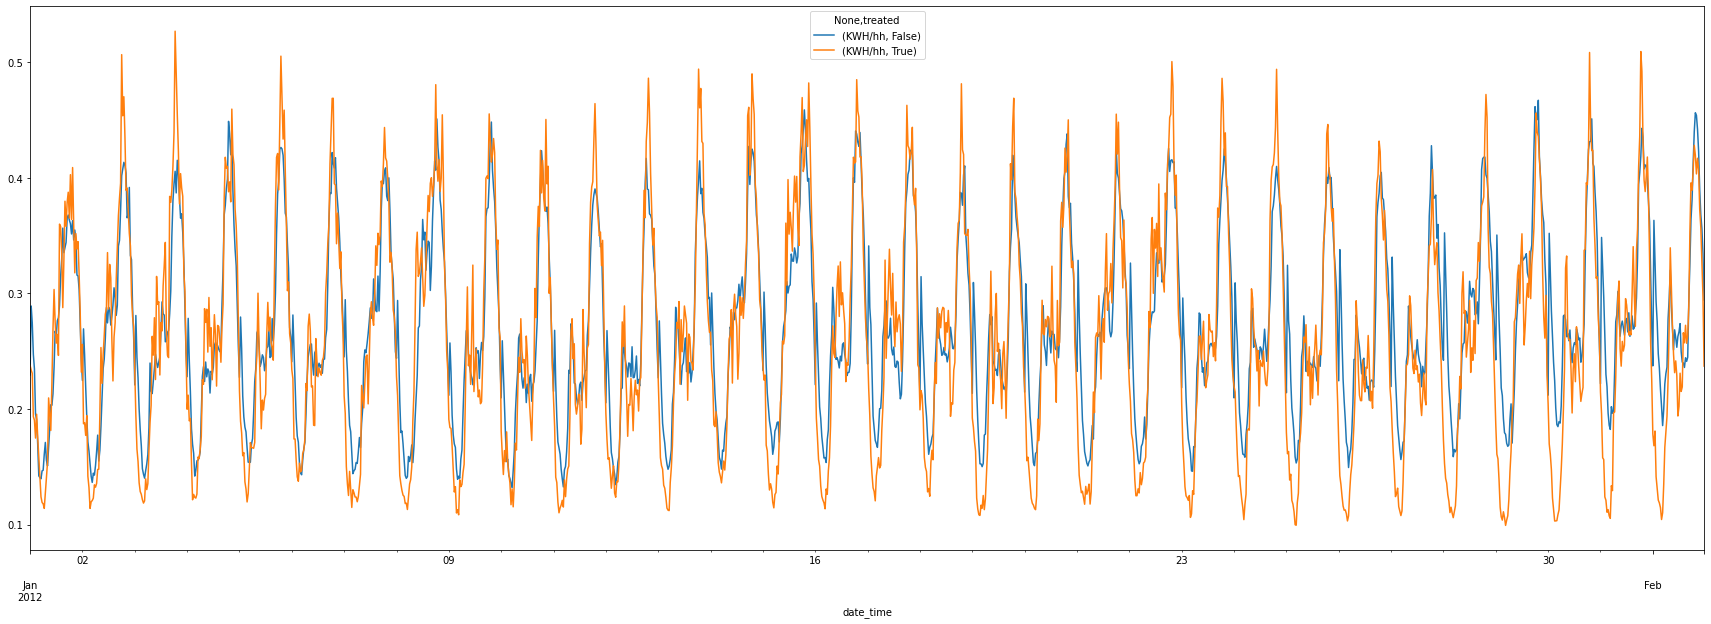

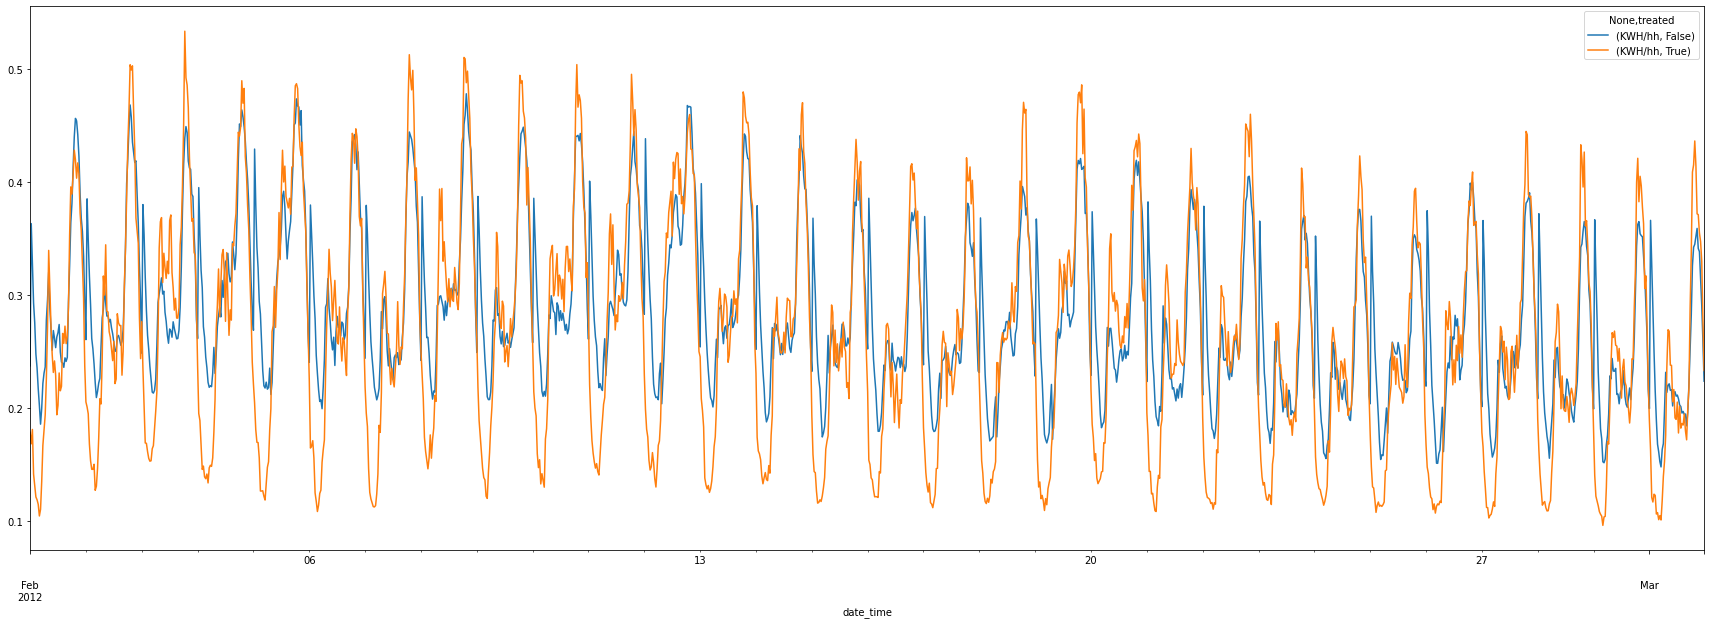

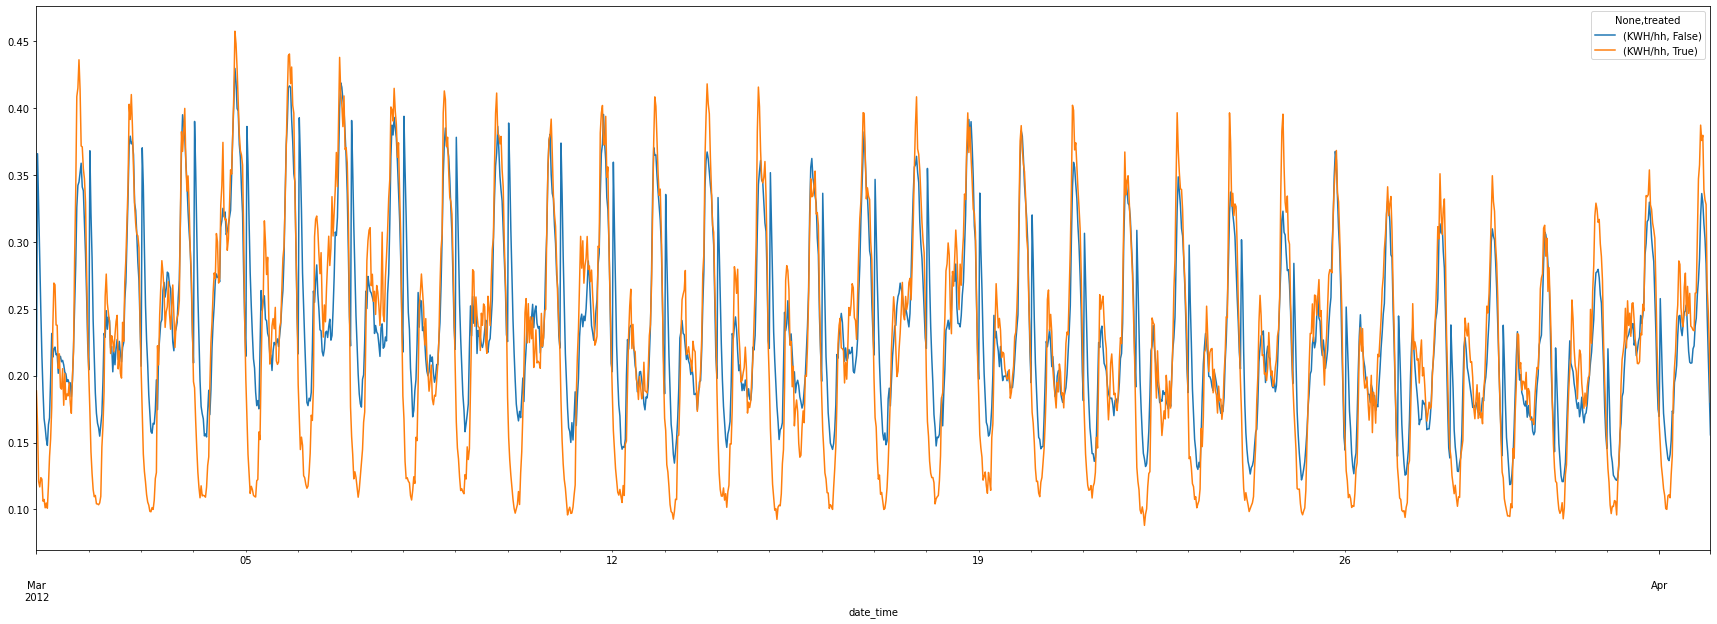

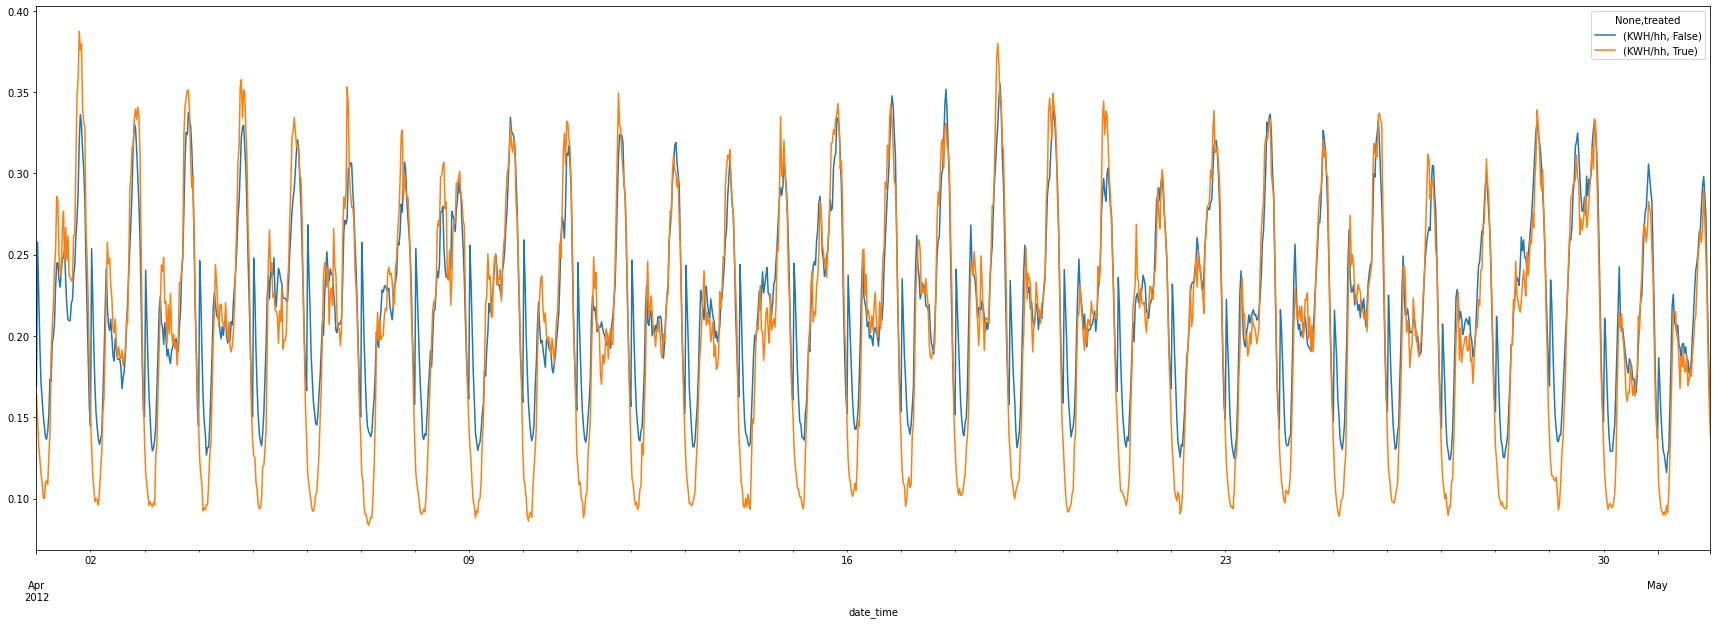

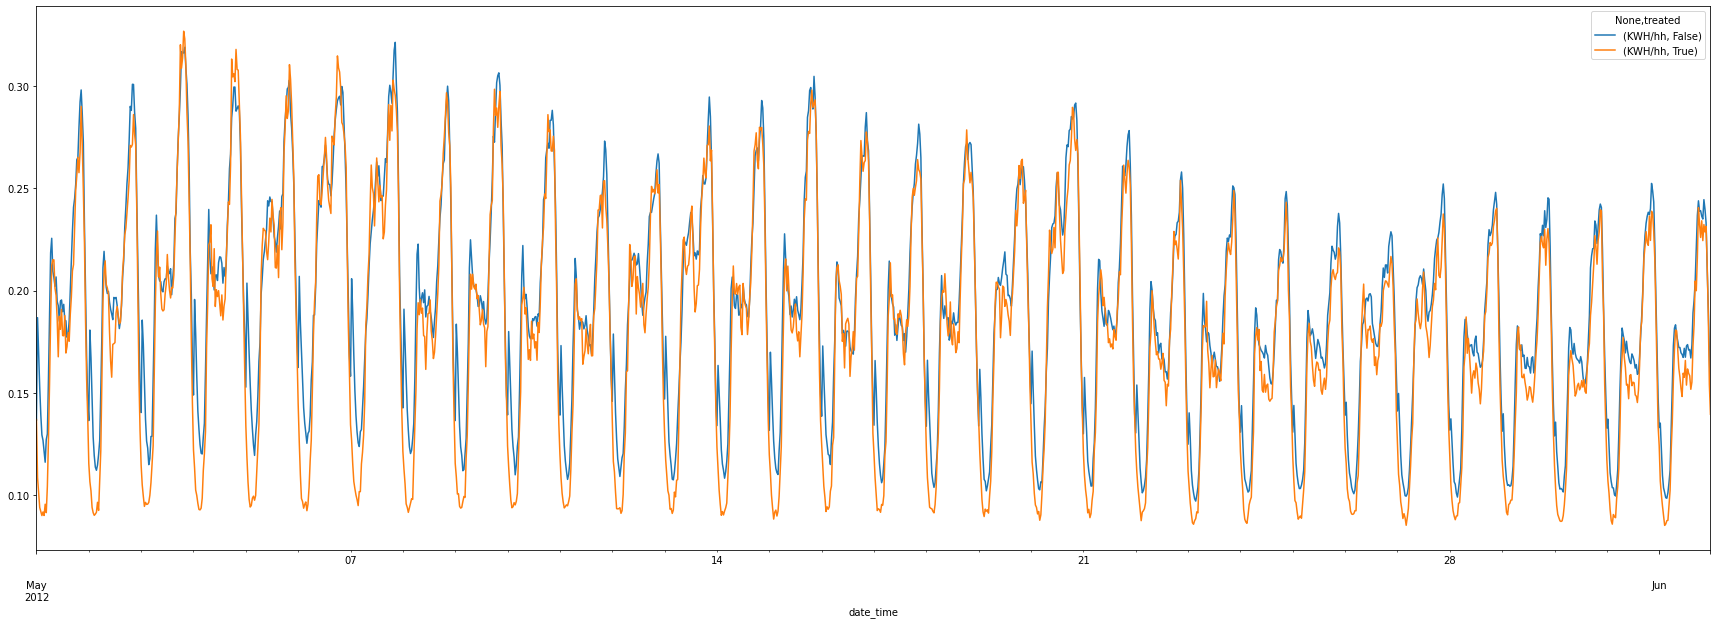

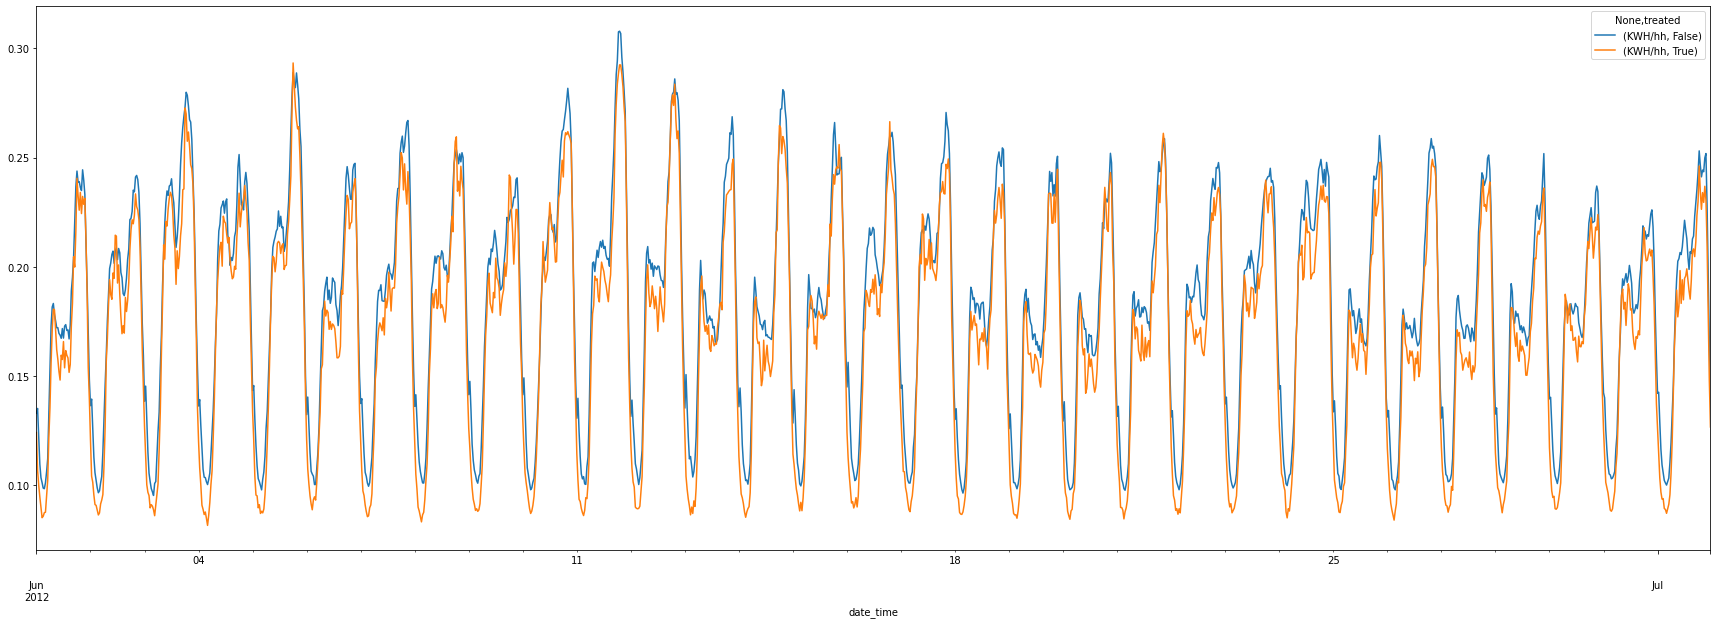

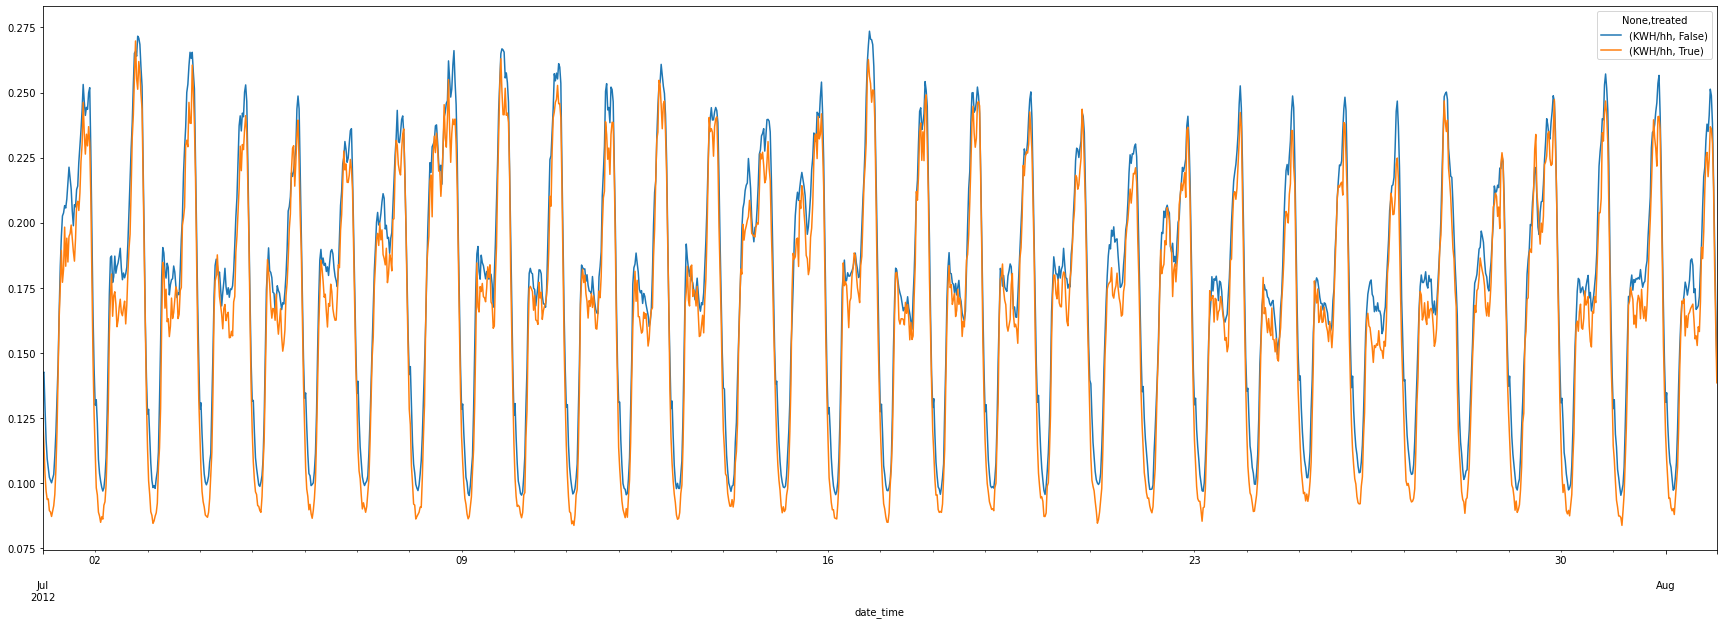

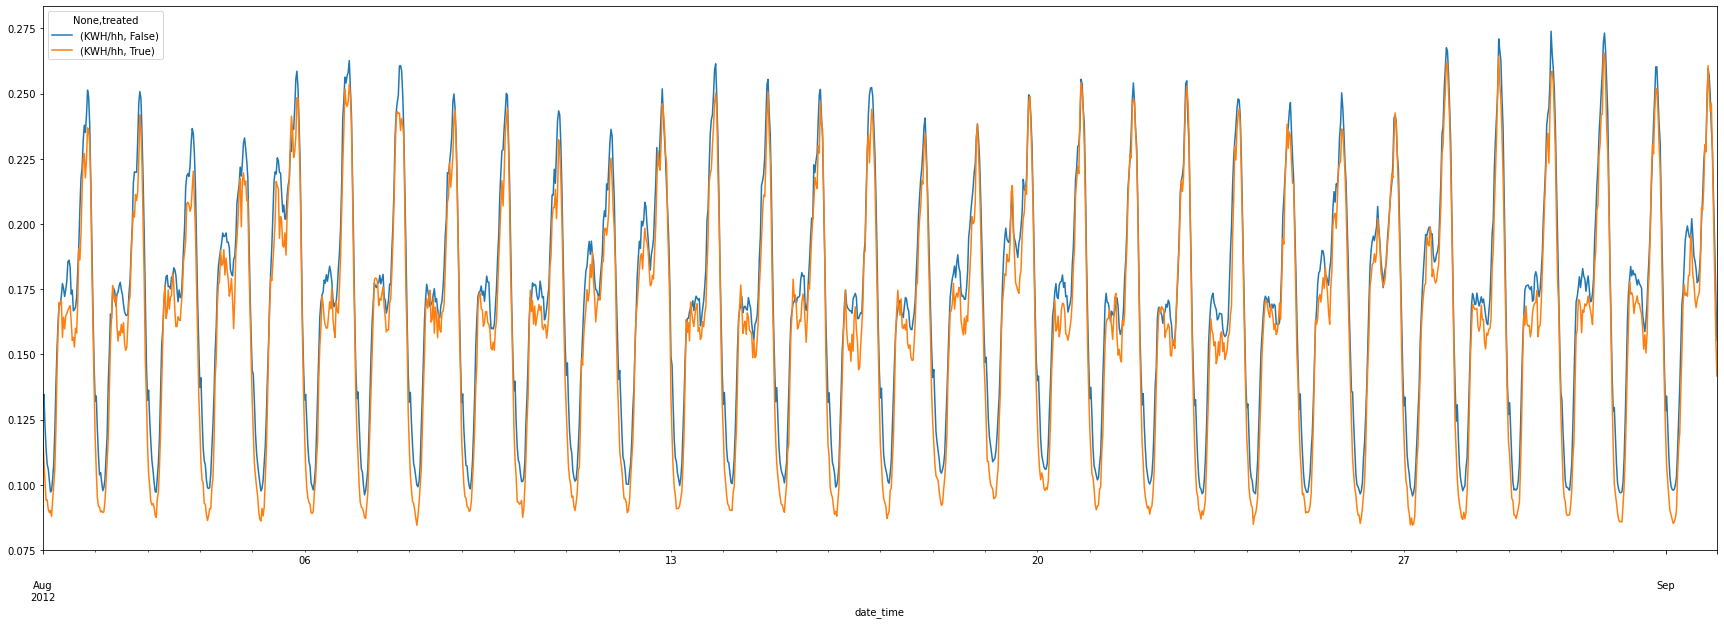

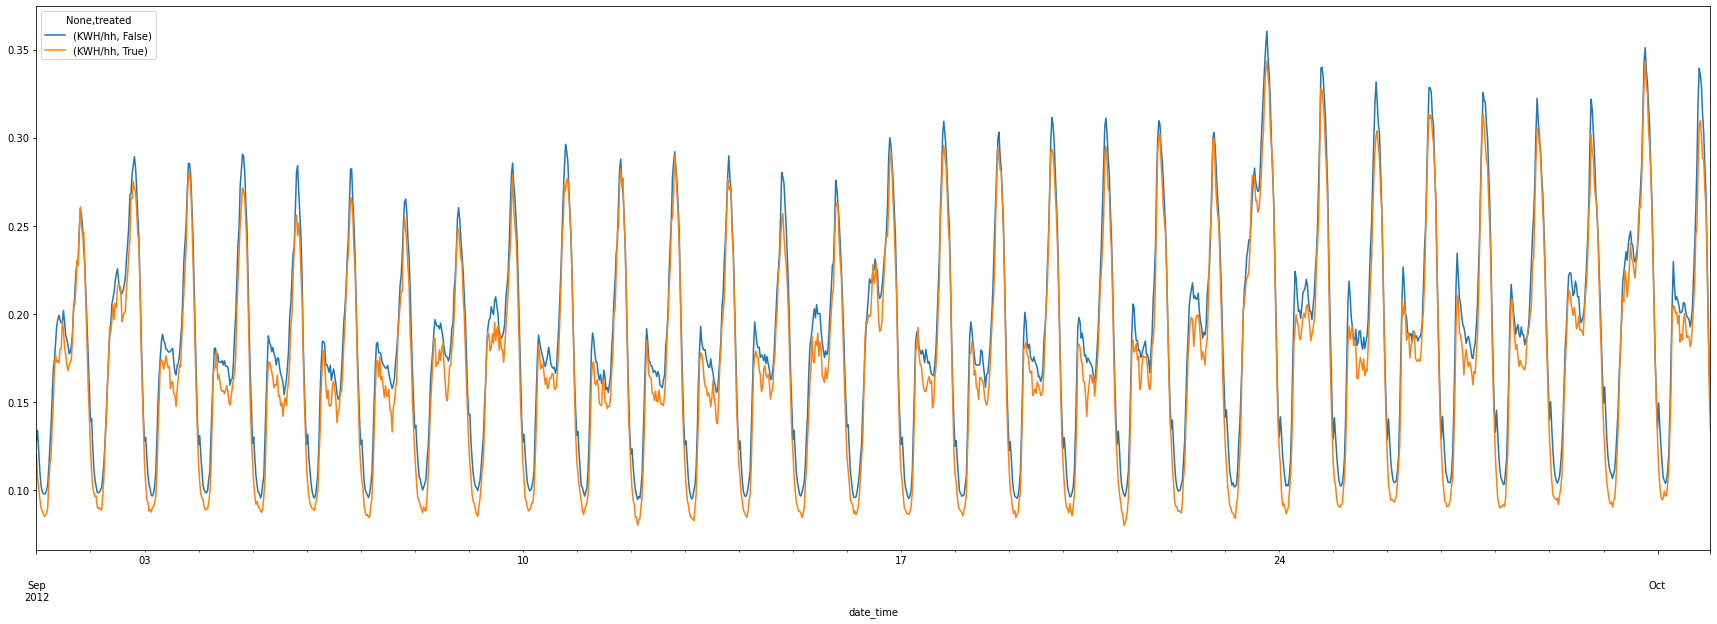

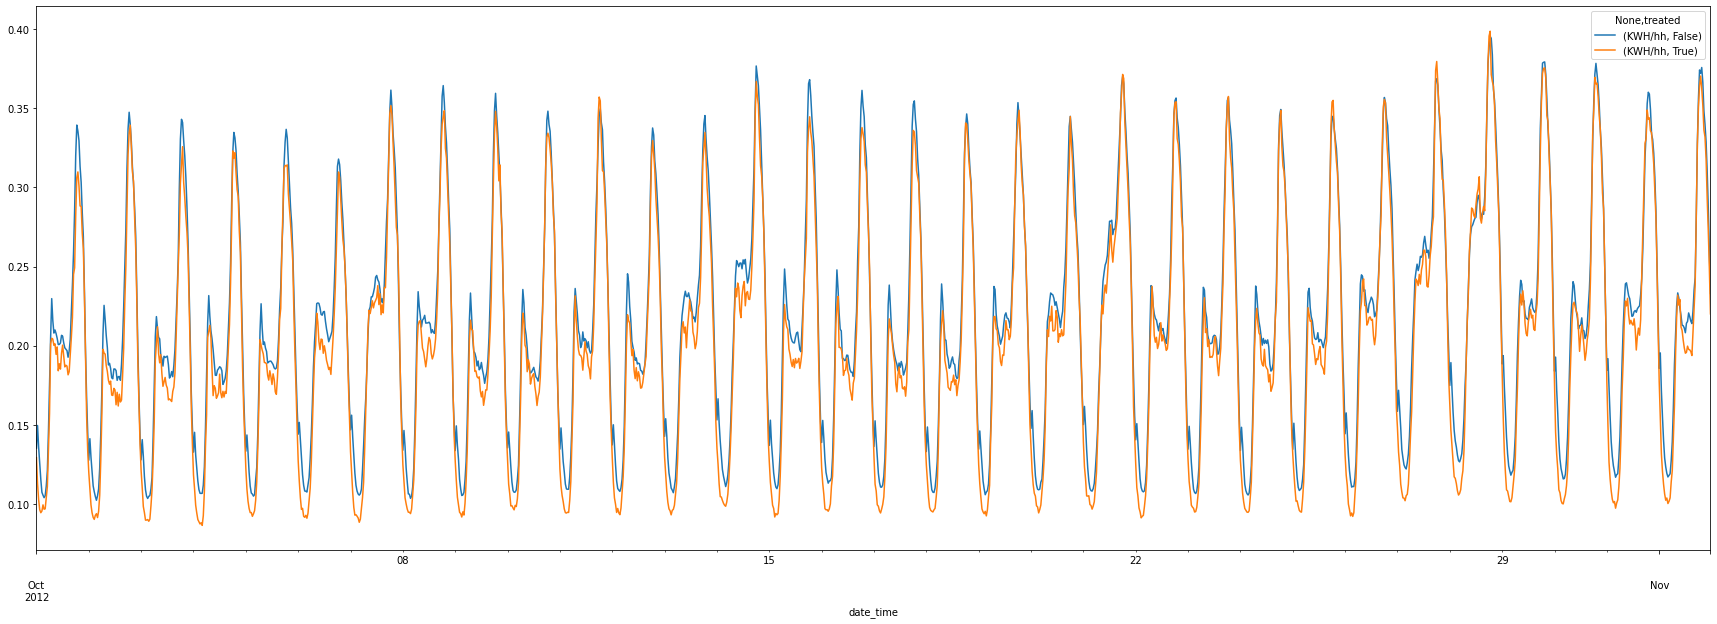

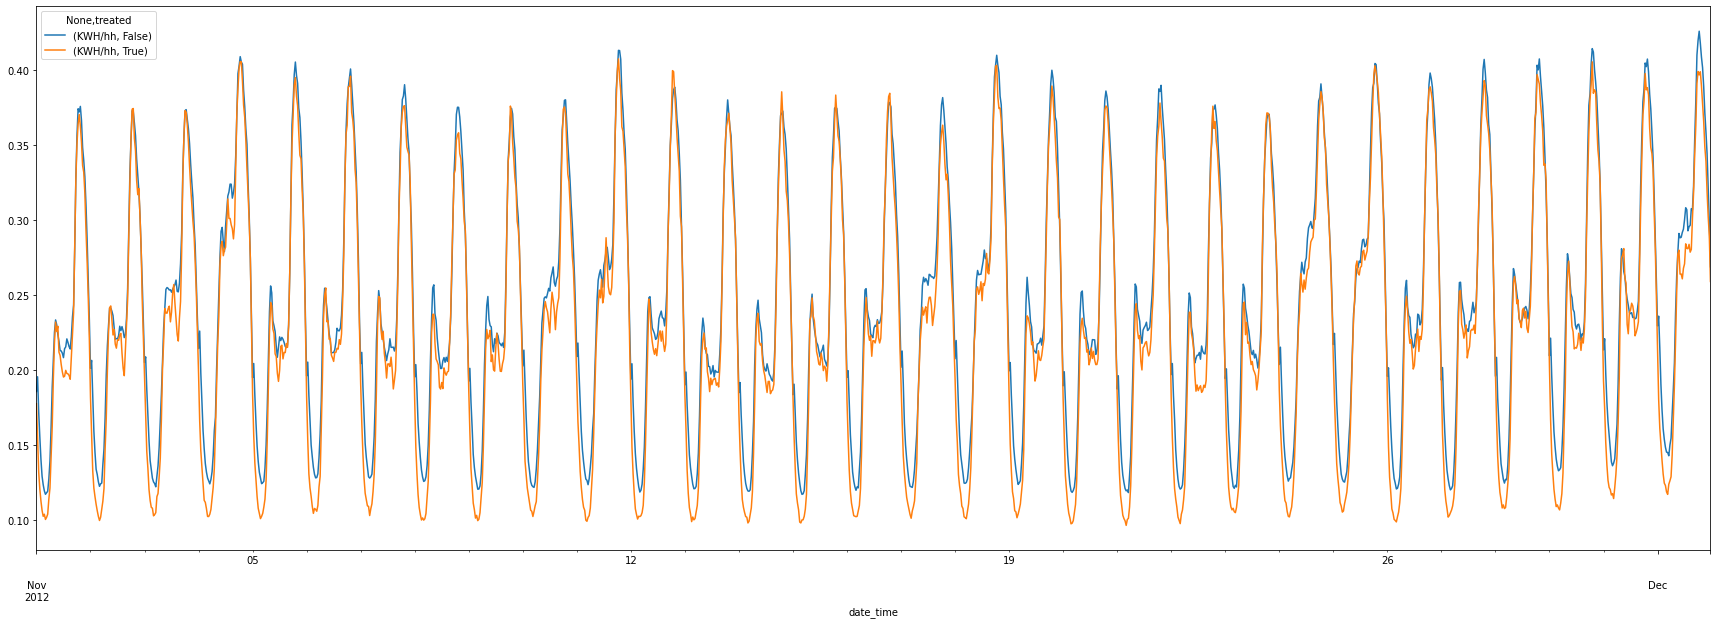

In [49]:
consumption_2012_hh_mean_jan.plot(figsize=(30,10))
consumption_2012_hh_mean_feb.plot(figsize=(30,10))
consumption_2012_hh_mean_mar.plot(figsize=(30,10))
consumption_2012_hh_mean_apr.plot(figsize=(30,10))
consumption_2012_hh_mean_may.plot(figsize=(30,10))
consumption_2012_hh_mean_jun.plot(figsize=(30,10))
consumption_2012_hh_mean_jul.plot(figsize=(30,10))
consumption_2012_hh_mean_aug.plot(figsize=(30,10))
consumption_2012_hh_mean_sep.plot(figsize=(30,10))
consumption_2012_hh_mean_nov.plot(figsize=(30,10))
consumption_2012_hh_mean_dec.plot(figsize=(30,10))

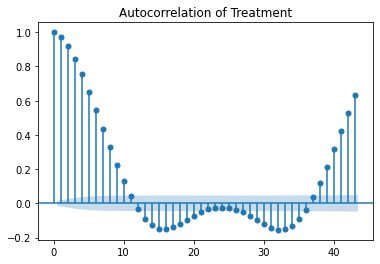

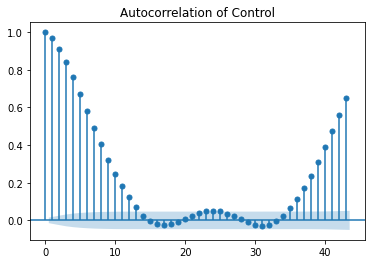

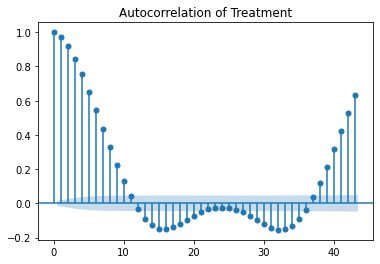

In [61]:
# Thinking about what we are actually doing here use AR/Ma/ARMA model to predict future consumption of both groups
# Show the differences in consumption based on the treatment

# Plot the autocorrelation and partial autocorrelation for all 2012
plot_acf(consumption_2012_hh_mean[('KWH/hh', False)], title = "Autocorrelation of Control")
plot_acf(consumption_2012_hh_mean[('KWH/hh', True)], title = "Autocorrelation of Treatment")

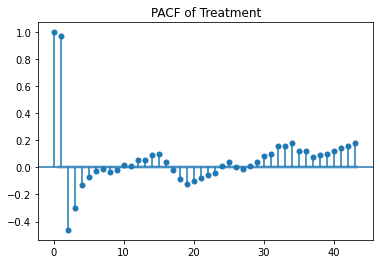

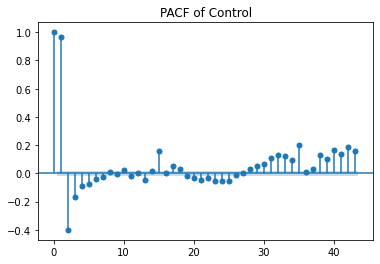

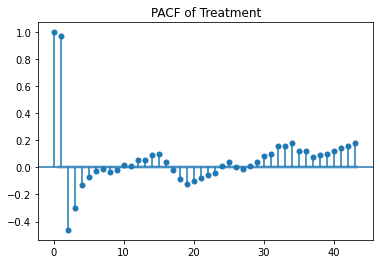

In [60]:
plot_pacf(consumption_2012_hh_mean[('KWH/hh', False)], title = 'PACF of Control')
plot_pacf(consumption_2012_hh_mean[('KWH/hh', True)], title = 'PACF of Treatment')

In [101]:
# # remove seasonality for ARIMA
# diff_cont_2012 = consumption_2012_hh_mean[('KWH/hh', False)].diff()
# diff_treat_2012 = consumption_2012_hh_mean[('KWH/hh', True)].diff()


# plot_acf(diff_cont_2012)
# plot_pacf(diff_cont_2012)

# plot_acf(diff_treat_2012)
# plot_pacf(diff_treat_2012)

In [63]:
# fit model
model = ARIMA(consumption_2012_hh_mean[('KWH/hh', False)], order=(24,1,0))
model_fit = model.fit()
print(model_fit.summary())

c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  warnings.warn('No frequency information was'
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  warnings.warn('No frequency information was'
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  warnings.warn('No frequency information was'
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile

                               SARIMAX Results                                
Dep. Variable:      ('KWH/hh', False)   No. Observations:                17568
Model:                ARIMA(24, 1, 0)   Log Likelihood               47135.218
Date:                Sun, 16 May 2021   AIC                         -94220.436
Time:                        13:57:26   BIC                         -94026.092
Sample:                    01-01-2012   HQIC                        -94156.451
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2836      0.004     72.083      0.000       0.276       0.291
ar.L2          0.0842      0.005     15.517      0.000       0.074       0.095
ar.L3          0.0201      0.007      2.976      0.0

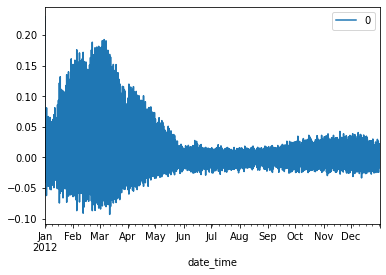

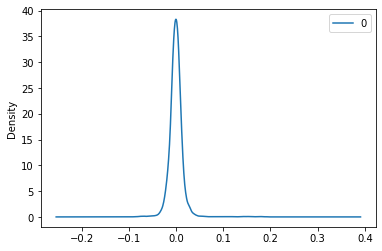

                  0
count  17568.000000
mean       0.000017
std        0.016630
min       -0.092942
25%       -0.007377
50%       -0.000514
75%        0.006288
max        0.229576


In [70]:
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

2013-01-01 00:00:00    0.233615
2013-01-01 00:30:00    0.228514
2013-01-01 01:00:00    0.225460
2013-01-01 01:30:00    0.222476
2013-01-01 02:00:00    0.223477
                         ...   
2013-12-31 21:30:00    0.276422
2013-12-31 22:00:00    0.276422
2013-12-31 22:30:00    0.276422
2013-12-31 23:00:00    0.276422
2013-12-31 23:30:00    0.276422
Freq: 30T, Name: predicted_mean, Length: 17520, dtype: float64


<ipython-input-87-1fc951e2c61a>:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000001689D83EC40>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend([cons,fore], ['consumption', 'forecast'])
<ipython-input-87-1fc951e2c61a>:9: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x000001689D8D6100>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend([cons,fore], ['consumption', 'forecast'])


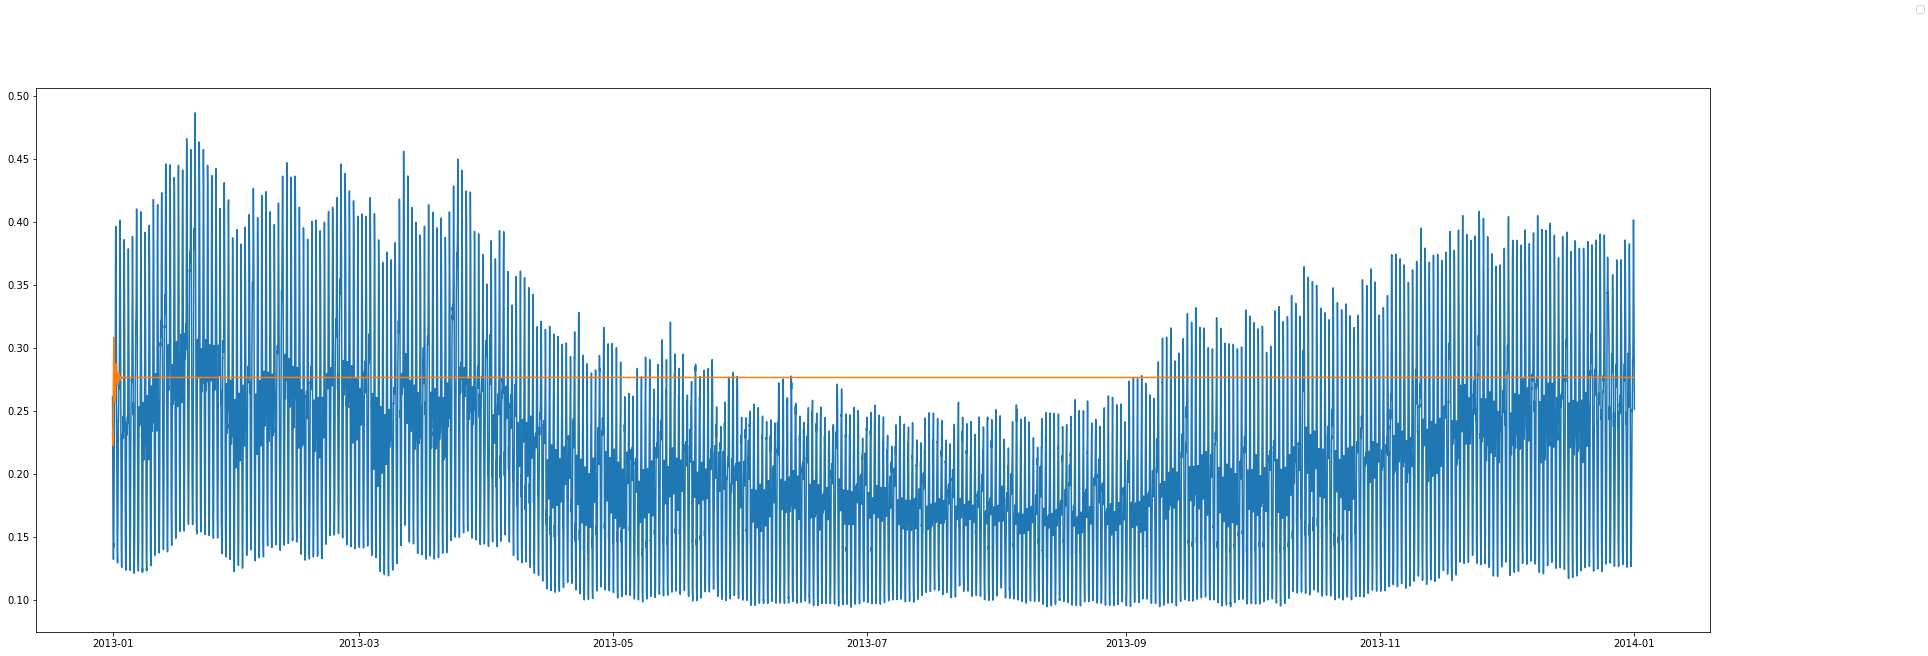

In [87]:
# Predict 2013 based on ARIMA model
predict_2013 = model_fit.predict(start='2013/01/01', end='2013/12/31')
forecast_2013 = model_fit.forecast(steps=365*24*2)
print(forecast_2013)

fig = plt.figure(figsize=(30,10))
cons= plt.plot(consumption_2013_hh_mean[('KWH/hh', False)])
fore = plt.plot(forecast_2013)
fig.legend([cons,fore], ['consumption', 'forecast'])

In [93]:
train = consumption_2012_hh_mean[('KWH/hh', False)]
history = [x for x in train]
test = consumption_2013_hh_mean[('KWH/hh', False)]
predictions = list()

<class 'list'>


In [95]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(14,1,10))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

KeyboardInterrupt: 

In [94]:
print(test[0])

0.2612695020468503


In [117]:
# Tyring using SARIMAX

model_sari = SARIMAX(consumption_2012_hh_mean_jan[('KWH/hh', False)], order=(7,1,1), seasonal_order=(1,1,1,30))
results_sari = model_sari.fit()
forecast_sari = results_sari.predict(start='2013/01/01', end='2013/01/31')

c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  warnings.warn('No frequency information was'
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  warnings.warn('No frequency information was'
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [122]:
forecast_sari_jan2012 = results_sari.predict(start='2012/01/01', end='2012/01/31')
forecast_sari_feb_2012 = results_sari.predict(start='2012/02/01', end='2012/02/28')

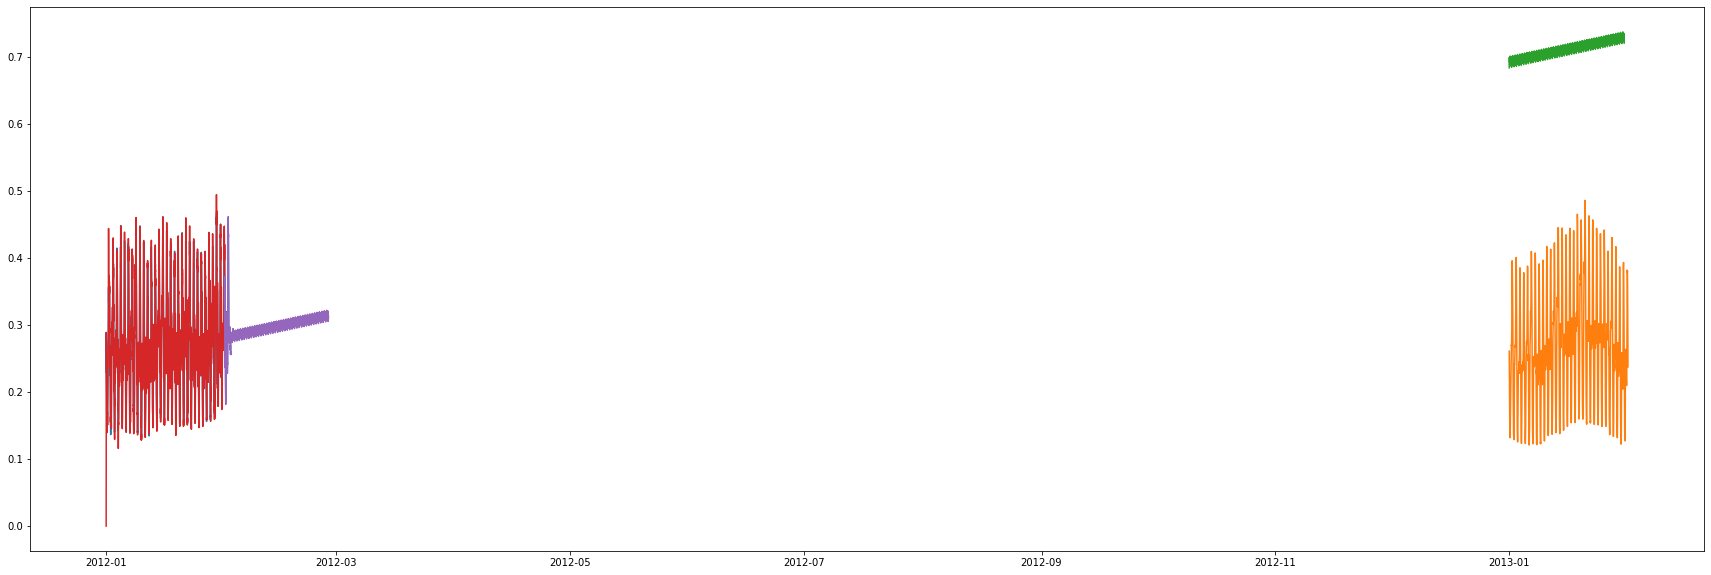

In [123]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(consumption_2012_hh_mean_jan[('KWH/hh', False)])
ax.plot(consumption_2013_hh_mean[('KWH/hh', False)]['2013/01/01':'2013/01/31'])
ax.plot(forecast_sari)
ax.plot(forecast_sari_jan2012)
ax.plot(forecast_sari_feb_2012)

In [145]:
# get daily consumption averages to use exog of temp or wind
consumption_2012_daily_mean = consumption_2012.groupby([consumption_2012['date_time'].dt.date, consumption_2012['treated']]).mean()
consumption_2012_daily_mean = consumption_2012_daily_mean.unstack()
consumption_2012_daily_mean.head()

KWH/hh          
treated        False     True 
date_time                     
2012-01-01  0.259550  0.260731
2012-01-02  0.265449  0.267626
2012-01-03  0.266683  0.275281
2012-01-04  0.265846  0.267715
2012-01-05  0.269332  0.263935

In [ ]:
# get daily consumption averages to use exog of temp or wind
consumption_2013_daily_mean = consumption_2013.groupby([consumption_2013['date_time'].dt.date, consumption_2013['treated']]).mean()
consumption_2013_daily_mean = consumption_2013_daily_mean.unstack()
print(consumption_2013_daily_mean.head())

In [175]:
# read in weather data
weather_df = pd.read_csv('weather.csv')
new_dt=[]
for item in weather_df['DT']:
    item = dt.strptime(item, '%Y-%m-%d').strftime('%Y-%m-%d')
    new_dt.append(item)
weather_df['DT']=new_dt
weather_df=weather_df.set_index(weather_df['DT'])
display(weather_df)

T2M_RANGE    TS  T2MDEW  T2MWET  T2M_MAX  T2M_MIN    T2M  \
DT                                                                     
2012-01-01       4.28  9.84    9.64    9.64    11.34     7.06  10.33   
2012-01-02       1.96  5.59    4.31    4.32     6.84     4.88   5.68   
2012-01-03       6.40  7.79    5.98    5.98    11.71     5.31   8.21   
2012-01-04       5.19  6.04    4.33    4.33     8.52     3.33   6.21   
2012-01-05       4.87  7.78    4.94    4.94    10.17     5.31   8.21   
...               ...   ...     ...     ...      ...      ...    ...   
2014-12-27       5.42  3.02    1.67    1.68     6.80     1.38   2.46   
2014-12-28       6.24  0.56   -0.39   -0.38     4.63    -1.61   0.38   
2014-12-29       5.80  0.67   -0.08   -0.08     3.98    -1.82   0.16   
2014-12-30       6.27  1.09    0.79    0.79     5.04    -1.24   0.89   
2014-12-31       5.88  3.26    2.66    2.66     6.25     0.37   3.50   

            WS50M_RANGE  WS10M_RANGE  WS50M_MIN  WS50M_MAX  WS10M_MIN  \
DT                                                                      
2012-01-01         3.32         3.11       7.94      11.26       5.14   
2012-01-02         3.60         3.03       7.04      10.64       4.75   
2012-01-03        13.29        10.69      10.57      23.86       7.79   
2012-01-04         9.64         7.65       9.52      19.16       6.98   
2012-01-05         8.42         6.93      12.36      20.78       8.89   
...                 ...          ...        ...        ...        ...   
2014-12-27        11.61         9.61       7.91      19.52       5.88   
2014-12-28         5.55         4.59       4.23       9.77       2.84   
2014-12-29         3.15         2.48       4.16       7.31       3.16   
2014-12-30         2.98         1.60       4.12       7.10       3.02   
2014-12-31         5.31         3.76       4.70      10.00       3.37   

            WS10M_MAX  WS50M  WS10M          DT  
DT                                               
2012-01-01       8.25  10.03   7.22  2012-01-01  
2012-01-02       7.77   8.88   6.42  2012-01-02  
2012-01-03      18.48  17.03  12.91  2012-01-03  
2012-01-04      14.62  13.53  10.24  2012-01-04  
2012-01-05      15.83  17.45  13.08  2012-01-05  
...               ...    ...    ...         ...  
2014-12-27      15.49  11.93   9.41  2014-12-27  
2014-12-28       7.44   7.25   5.10  2014-12-28  
2014-12-29       5.64   6.30   4.52  2014-12-29  
2014-12-30       4.62   5.45   3.63  2014-12-30  
2014-12-31       7.14   7.82   5.45  2014-12-31  

[1096 rows x 16 columns]

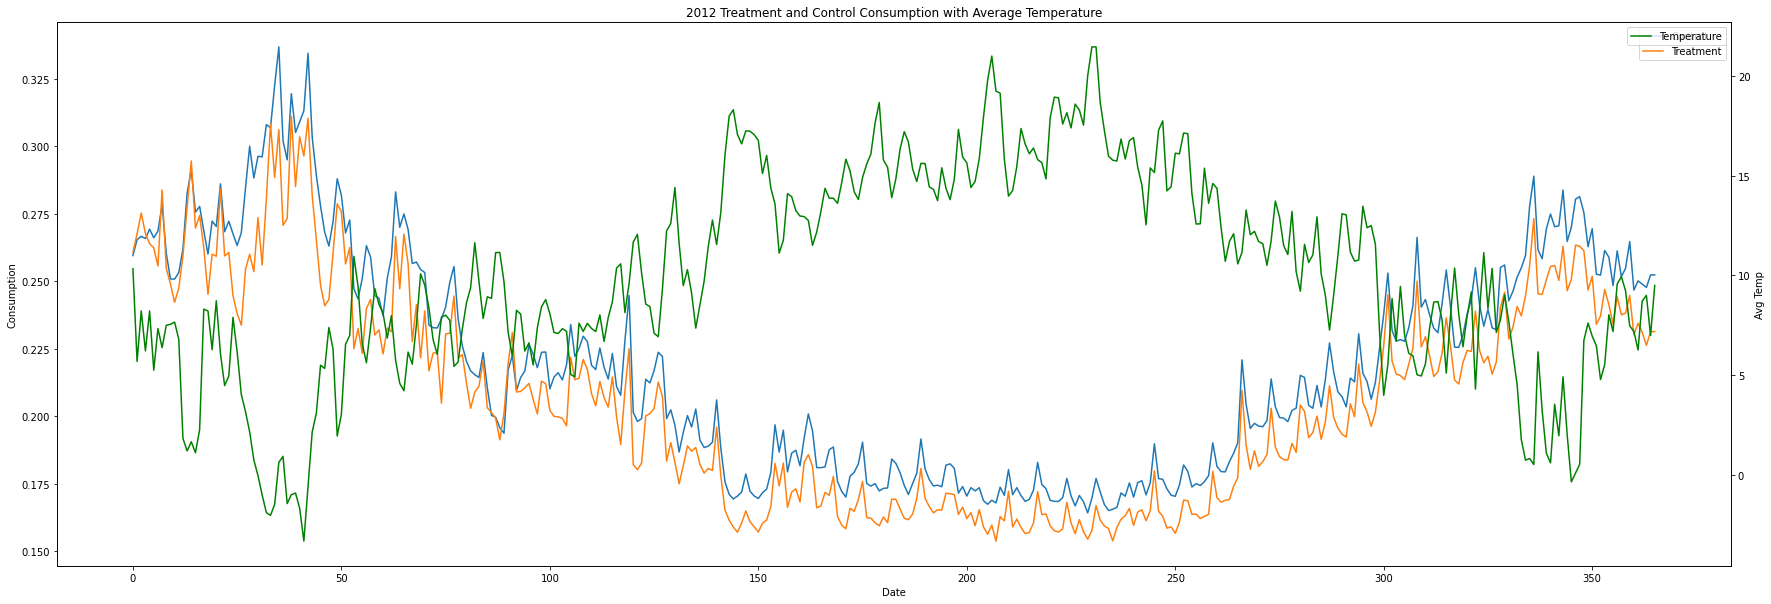

In [197]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(consumption_2012_daily_mean[('KWH/hh', False)].reset_index(drop=True), label='Control')
ax.plot(consumption_2012_daily_mean[('KWH/hh', True)].reset_index(drop=True), label='Treatment')
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
ax2 = ax.twinx()
ax2.set_ylabel('Avg Temp')
weather_plot = weather_df['T2M']['2012-01-01':'2012-12-31'].reset_index(drop=True)
ax2.plot(weather_plot, color='green', label='Temperature')
plt.title('2012 Treatment and Control Consumption with Average Temperature')
ax.legend()
ax2.legend()
plt.show()

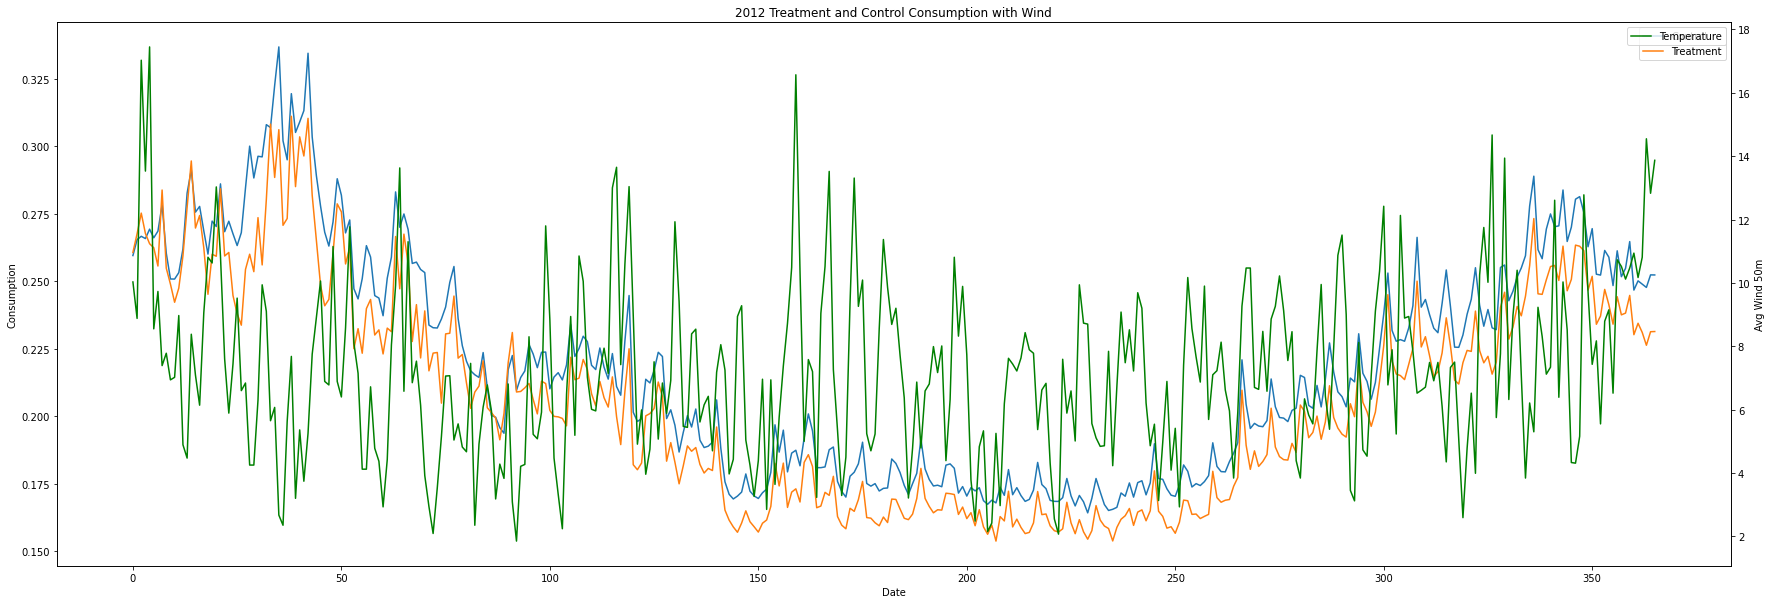

In [198]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(consumption_2012_daily_mean[('KWH/hh', False)].reset_index(drop=True), label='Control')
ax.plot(consumption_2012_daily_mean[('KWH/hh', True)].reset_index(drop=True), label='Treatment')
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
ax2 = ax.twinx()
ax2.set_ylabel('Avg Wind 50m')
weather_plot = weather_df['WS50M']['2012-01-01':'2012-12-31'].reset_index(drop=True)
ax2.plot(weather_plot, color='green', label='Temperature')
plt.title('2012 Treatment and Control Consumption with Wind')
ax.legend()
ax2.legend()
plt.show()

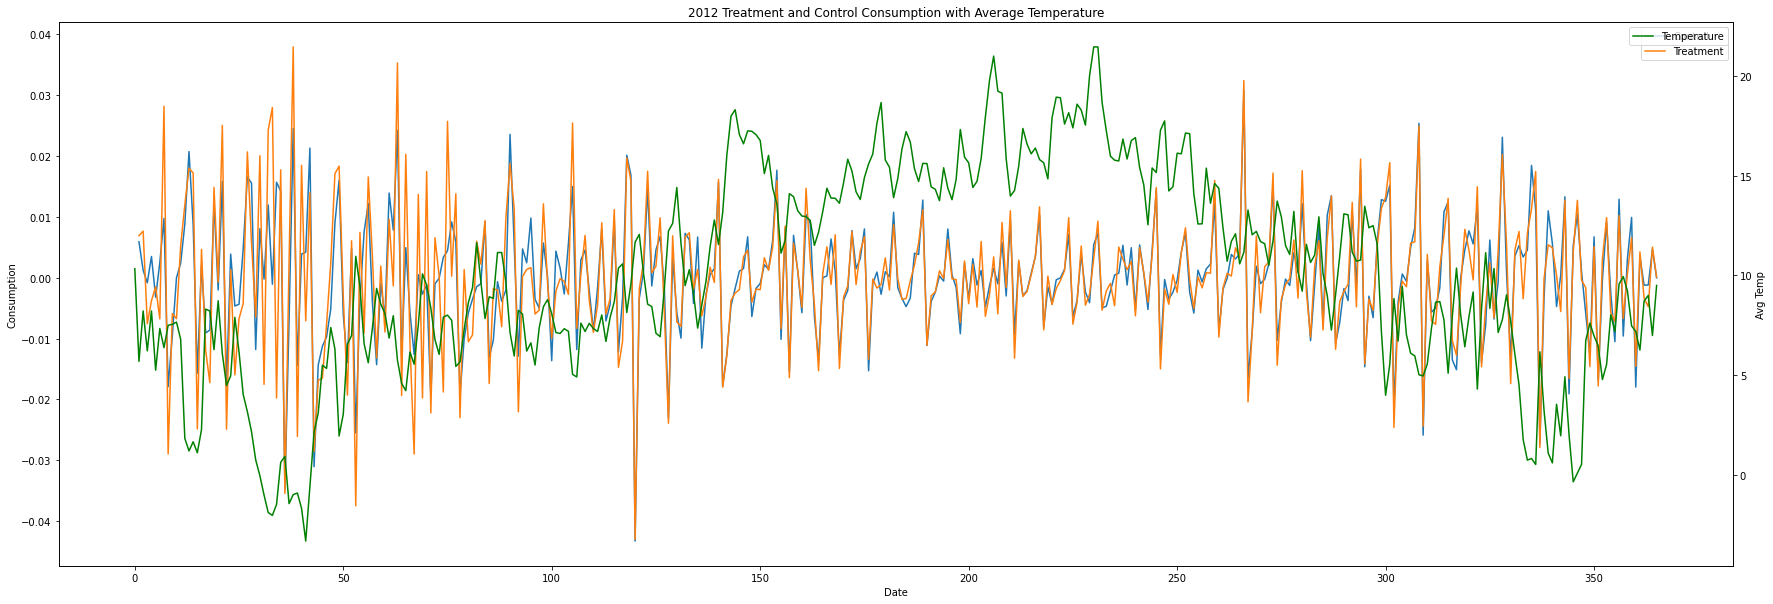

In [201]:
cont_2012_diff = consumption_2012_daily_mean[('KWH/hh', False)].diff().reset_index(drop=True)
treat_2012_diff = consumption_2012_daily_mean[('KWH/hh', True)].diff().reset_index(drop=True)
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(cont_2012_diff, label='Control')
ax.plot(treat_2012_diff, label='Treatment')
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
ax2 = ax.twinx()
ax2.set_ylabel('Avg Temp')
weather_plot = weather_df['T2M']['2012-01-01':'2012-12-31'].reset_index(drop=True)
ax2.plot(weather_plot, color='green', label='Temperature')
plt.title('2012 Treatment and Control Consumption with Average Temperature')
ax.legend()
ax2.legend()
plt.show()

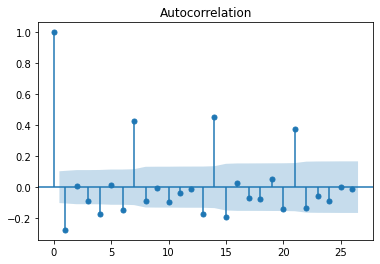

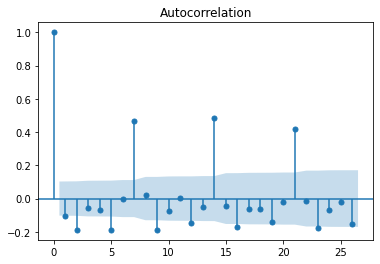

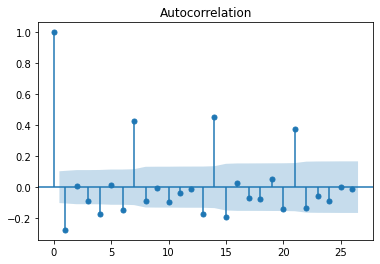

In [207]:
plot_acf(cont_2012_diff.dropna())
plot_acf(treat_2012_diff.dropna())

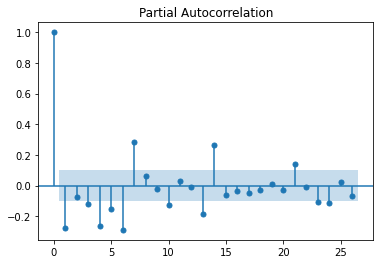

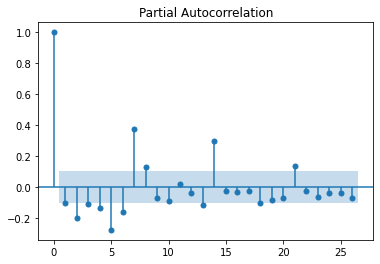

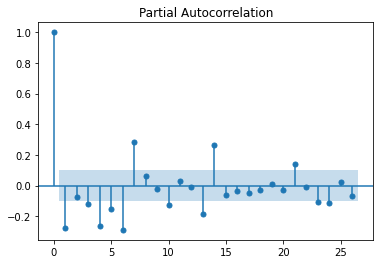

In [208]:
plot_pacf(cont_2012_diff.dropna())
plot_pacf(treat_2012_diff.dropna())

In [221]:
# fit model
model_noexog = ARIMA(cont_2012_diff.dropna(), order=(7,1,1))
model_fit_noexog = model_noexog.fit()
print(model_fit.summary())

c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as st

                               SARIMAX Results                                
Dep. Variable:      ('KWH/hh', False)   No. Observations:                  365
Model:                 ARIMA(1, 1, 7)   Log Likelihood                1185.982
Date:                Sun, 16 May 2021   AIC                          -2351.964
Time:                        18:53:20   BIC                          -2312.993
Sample:                             0   HQIC                         -2336.475
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T2M           -0.0008      0.000     -4.428      0.000      -0.001      -0.000
ar.L1         -0.4512      0.259     -1.739      0.082      -0.960       0.057
ma.L1         -0.5468      0.259     -2.109      0.0

c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [222]:
# fit model
model_exog = ARIMA(cont_2012_diff.dropna(), exog=weather_plot[1:], order=(7,1,1))
model_fit_exog = model_exog.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      ('KWH/hh', False)   No. Observations:                  365
Model:                 ARIMA(1, 1, 7)   Log Likelihood                1185.982
Date:                Sun, 16 May 2021   AIC                          -2351.964
Time:                        18:53:44   BIC                          -2312.993
Sample:                             0   HQIC                         -2336.475
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T2M           -0.0008      0.000     -4.428      0.000      -0.001      -0.000
ar.L1         -0.4512      0.259     -1.739      0.082      -0.960       0.057
ma.L1         -0.5468      0.259     -2.109      0.0

In [226]:
weather_plot_exog = weather_df['T2M']['2013-01-01':'2013-12-31'].reset_index(drop=True)
# see what the two predictions look like
pred_noexog= model_fit_noexog.predict(start=366, end=366+365)
pred_exog= model_fit_exog.predict(start=366, end=366+363, exog=weather_plot_exog)

c:\users\landw\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


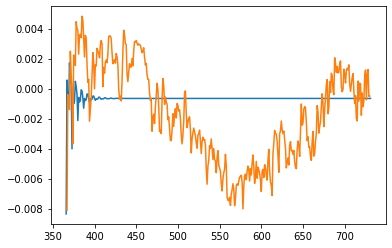

In [228]:
plt.plot(pred_noexog)
plt.plot(pred_exog)
plt.plot()